In [14]:
import sys
sys.path.append("..")

import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
import os
from spiralcutter_advanced.libs.spiral_funcs import *
from spiralcutter_advanced.libs.profile_funcs import *
from spiralcutter_advanced.libs.helper_funcs import *
from scipy.optimize import curve_fit
from astropy.io import fits

In [18]:
messier_dict = {
    "NGC 0628": "MESSIER 074",
    "NGC 4254": "MESSIER 099",
    "NGC 4303": "MESSIER 061",
    "NGC 4321": "MESSIER 100",
    "NGC 5236": "MESSIER 083"
}

cr_db = pd.read_csv("../other/corotations.csv")

bad_arms = {
        "NGC0613": [],
        "NGC0628": [],
        "NGC0986": [],
        "NGC1042": [],
        "NGC1073": [],
        "NGC1232": ["blue", "green", "yellow"],
        "NGC1300": ["blue"],
        "NGC1566": ["blue", "cyan"],
        "NGC1672": ["yellow"],
        "NGC3184": ["cyan", "orange"],
        "NGC4123": [],
        "NGC4254": ["cyan", "yellow"],
        "NGC4303": ["yellow"],
        "NGC4321": ["blue", "magenta", "yellow"],
        "NGC4535": ["orange", "teal", "yellow"],
        "NGC5085": [],
        "NGC5236": ["cyan", "magenta", "yellow"],
        "NGC5247": [],
        "NGC7412": []
}

def find_disc_params(gal, fn):
    path = f"../galaxies_images/{gal}/{fn}"
    disc_found = False
    h = []
    r_br = np.nan
    with open(path, "r") as file:
        for line in file:
            if line.startswith("FUNCTION Exponential") or line.startswith("FUNCTION BrokenExponential"):
                disc_found = True
            if not disc_found:
                continue
            if line.startswith("h"):
                h.append(float(line.split()[1]) * 0.75)
            if line.startswith("r_break"):
                r_br = float(line.split()[1]) * 0.75
    return (h, r_br)

def find_corotations(gal):
    galname = f"{gal[:3]} {gal[3:]}"
    if galname in messier_dict:
        galname = messier_dict[galname]
    cr_list = cr_db.loc[cr_db["Unnamed: 0"] == galname, "cr"].tolist()[0][1:-1]
    cr_r = cr_db.loc[cr_db["Unnamed: 0"] == galname, "cr_range"].tolist()[0][2:-2].split("], [")
    #cr_r_min = cr_r[0].split(", ")
    #cr_r_max = cr_r[1].split(", ")
    #print(cr_errs)
    cr_arr = []
    crmin_arr = []
    crmax_arr = []
    for cr in cr_list.split(", "):
        cr_arr.append(float(cr))
    for crmin in cr_r[0].split(", "):
        crmin_arr.append(float(crmin))
    for crmax in cr_r[1].split(", "):
        crmax_arr.append(float(crmax))
    cr_arr = np.array(cr_arr)
    cr_min = np.array(crmin_arr)
    cr_max = np.array(crmax_arr)
    nona = ~np.isnan(cr_arr)
    return(cr_arr[nona], cr_min[nona], cr_max[nona])

def find_arms_shapes(gal, path_sh = None):
    funcs_list = [sp_o1, sp_o2, sp_o3, sp_o4, sp_o5, sp_o1_br1, sp_o2_br1, sp_o3_br1, sp_o1_br2, sp_o2_br2]
    if path_sh is None:
        path_sh = f"../galaxies_images/{gal}/spiral_params/shapes.dat"
    
    phi_list = []
    psi_list = []
    r_list = []
    col_list = []
    
    with open(path_sh, "r") as file:
        for line in file:
            col, fname, phi0, phie = line.split()[0:4]
            phi0 = float(phi0)
            phie = float(phie)
            this_func = None
            for func in funcs_list:
                if func.__name__ == fname:
                    this_func = func
            params = line.split("[")[1].split("]")[0]
            params = np.array(params.split()).astype(float)
            if np.isnan(params[0]):
                continue
            psi_arr = np.radians(np.arange(-30, np.abs(phie - phi0) + 30, 1))
            phi_arr = np.radians(np.arange(phi0 - (30 * np.sign(phie - phi0)), phie + (30 * np.sign(phie - phi0)), 1))
            r_arr = this_func(psi_arr, *params)
            psi_list.append(psi_arr)
            phi_list.append(phi_arr)
            r_list.append(r_arr)
            col_list.append(col)
    
    g_i = col_list.index("green")
    if r_list[g_i][0] > r_list[g_i][-1]:
        for i in range(len(col_list)):
            psi_list[i] = np.abs(psi_list[i] - np.max(psi_list[i]))
            psi_list[i] = np.flip(psi_list[i])
            phi_list[i] = np.flip(phi_list[i])
            r_list[i] = np.flip(r_list[i])
    return (col_list, psi_list, phi_list, r_list)
    
def find_arms_profiles(gal, path_prof = None):
    if path_prof is None:
        path_prof = f"../galaxies_images/{gal}/spiral_params/profiles_2d_final.dat"
    
    col_list = []
    rzs_list = []
    ld_list = []
    lduv_list = []
    off_list = []
    n_list = []
    S_list = []
    
    col_prev = None
    rzs = np.nan
    ld = np.array([np.nan])
    off = np.array([np.nan, np.nan])
    lduv = np.array([np.nan])
    n = np.nan
    S = np.array([np.nan, np.nan])
    
    with open(path_prof, "r") as file:
        for line in file:
            col, fname = line.split()[0:2]
            
            if col in bad_arms[gal]:
                continue
                    
            params = line.split("[")[1].split("]")[0]
            params = np.array(params.split()).astype(float)
            
            if ~np.isnan(params[0]):
                if fname == "main_func_w_asymm":
                    S0 = params[-2]
                    S1 = params[-1]
                    rzs = -S0 / S1
                    off = np.array([params[0], params[1]])
                    S = np.array([S0, S1])
                if fname == "main_func_w_n":
                    n = params[-1]
                if fname == "main_func_d1":
                    ld = np.array([params[-2]])
                if fname == "main_func_d2":
                    ld = np.array([params[-5], params[-2]])
                
            if fname == "main_func_cw" and (col_prev is not None): #approached next color
                col_list.append(col_prev)
                rzs_list.append(rzs)
                ld_list.append(ld)
                off_list.append(off)
                n_list.append(n)
                S_list.append(S)
                r_zs = np.nan
                ld = np.array([np.nan])
                off = np.array([np.nan, np.nan])
                n = np.nan
                S = np.array([np.nan, np.nan])
            
            col_prev = col
            
        col_list.append(col_prev)
        rzs_list.append(rzs)
        ld_list.append(ld)
        off_list.append(off)
        n_list.append(n)
        S_list.append(S)
    return col_list, rzs_list, ld_list, off_list, n_list, S_list

def lin_0(x, a):
    return a * x

def lin_b(x, a, b):
    return a * x + b

gals = []
gal_paths = glob.glob("../galaxies_images/*")
for path in gal_paths:
    gals.append(path.split("/")[-1])
gals = np.sort(gals)

# disc breaks / spiral breaks / corotations

[79.8  70.17 70.17 71.15]
[72.   33.94 33.94 31.98]
[ 87.6  106.4  106.4  110.31]
red, r_bend: 76.409
green, zero skewness: 69.413
green, dips: [56.633 89.368]
green, dips_uv: [54.302 85.784]
red, zero skewness: nan
red, dips: [52.647 86.648]
red, dips_uv: [45.106 88.95 ]


/tmp/ipykernel_20058/3262242603.py:100: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


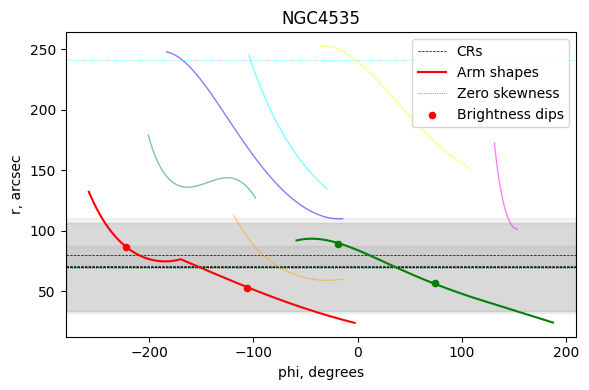

In [21]:
#for gal in gals:

n_arr = []

for gal in ["NGC4535"]:
    fig, ax = plt.subplots(figsize=[6, 4])
    
    any_dips = False
    
    h_disc, r_br = find_disc_params(gal, "fit_nosp.imfit")
    crs, crmins, crmaxs = find_corotations(gal)
    print(crs)
    print(crmins)
    print(crmaxs)
    cols, psis, phis, rs = find_arms_shapes(gal)
    cols_2d, rzss, lds, offs, ns, Ss = find_arms_profiles(gal)
    cols_uv, rzss_uv, lds_uv, offs_uv, ns_uv, Ss_uv = find_arms_profiles(gal, path_prof = f"../gals_uv/{gal}/spiral_params/profiles_2d_final.dat")
    
    #print(cols)
    #print(rzs)
    #print(lds)
    
    for i in range(len(crs) - 1):
        cr = crs[i + 1]
        crmin = crmins[i + 1]
        crmax = crmaxs[i + 1]
        ax.axhline(cr, ls = "--", lw = 0.5, c = "k")
        ax.axhspan(crmin, crmax, color = "k", alpha = 0.05)
    ax.axhline(crs[0], ls = "--", lw = 0.5, c = "k", label = "CRs")
    ax.axhspan(crmins[0], crmaxs[0], color = "k", alpha = 0.05)
    
    if ~np.isnan(r_br):
        ax.axhline(r_br, ls = "-", lw = 3, alpha = 0.25, c = "k", label = "Disc break")
    
    for i in range(len(cols)):
        col = cols[i]
        psi = psis[i]
        phi = phis[i]
        if col == "green":
            phi = phi + np.radians(360)
        r = rs[i]
        if (col in bad_arms[gal]) or (np.degrees(psi[-1]) < 240):
            ax.plot(np.degrees(phi)[30:-30], r[30:-30], c = col, alpha = 0.5, lw = 1)
        else:
            ax.plot(np.degrees(phi)[30:-30], r[30:-30], c = col)
            
        if col == "red":
            dmu = np.gradient(np.gradient(r))
            i_bend = np.argmin(dmu)
            r_bend = r[i_bend]
            print(f"{col}, r_bend: {np.round(r_bend, 3)}")
        
    for i in range(len(cols_2d)):
        col = cols_2d[i]
        rzs = rzss[i]
        off = offs[i]
        off_uv = offs_uv[i]
        
        i_all = cols.index(col)
        if (rzs < 0) or rzs > np.nanmax(1.25 * rs[i_all][30:-30]):
            rzs = np.nan
        
        r_off = rs[i_all] * off[1] + off[0]
        r_true = rs[i_all] - r_off
        r_off_uv = rs[i_all] * off_uv[1] + off_uv[0]
        r_true_uv = rs[i_all] - r_off_uv
        
        if col == "green":
            phis[i_all] = phis[i_all] + np.radians(360)
        
        ld = np.degrees(np.interp(lds[i], psis[i_all], phis[i_all]))
        rd = np.interp(lds[i], psis[i_all], r_true)
        ld_uv = np.degrees(np.interp(lds_uv[i], psis[i_all], phis[i_all]))
        rd_uv = np.interp(lds_uv[i], psis[i_all], r_true_uv)
        
        radial_offset = r_true_uv - r_true
        cr_i = np.argmin(np.abs(radial_offset))
        
        #print(f"{col}, cr offsets: {r_off[30:-30:10]}")
        
        ax.scatter(ld, rd, c = col, marker = "o", s = 20)
        
        ax.axhline(rzs, c = col, ls = ":", lw = 0.5)
        
        if col in ["red", "green"]:
            print(f"{col}, zero skewness: {np.round(rzs, 3)}")
            print(f"{col}, dips: {np.round(rd, 3)}")
            print(f"{col}, dips_uv: {np.round(rd_uv, 3)}")
    
    ax.plot([], [], c = "r", label = "Arm shapes")
    ax.plot([], [], c = "r", ls = ":", lw = 0.5, label = "Zero skewness")
    ax.scatter([], [], c = "r", marker = "o", s = 20, label = "Brightness dips")
    ax.legend()
    ax.set_title(gal)
    ax.set_xlabel("phi, degrees")
    ax.set_ylabel("r, arcsec")
    fig.tight_layout()
    #fig.savefig(f"../images/plots/corotation_comp/{gal}", dpi = 300)
    fig.savefig(f"../images/selected/NGC4535_features", dpi = 300)
    fig.show()
    #plt.close(fig)

/tmp/ipykernel_6558/2489012246.py:87: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_6558/2489012246.py:108: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


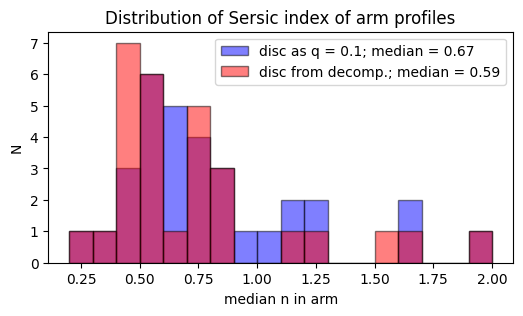

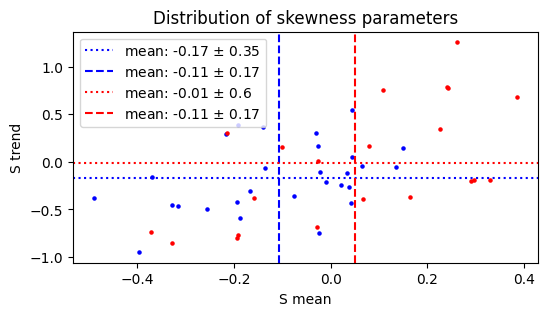

In [79]:
l_arr = []
r_arr = []
S_arr = []
n_arr = []

lm_arr = []
rm_arr = []
Sm_arr = []
nm_arr = []


for gal in gals:
    psis_2d = []
    psis_2d_m = []
    rs_2d = []
    rs_2d_m = []
    
    h_disc, r_br = find_disc_params(gal, "fit_nosp.imfit")
    crs = find_corotations(gal)
    cols, psis, _, rs = find_arms_shapes(gal)
    cols_2d, _, _, _, ns, Ss = find_arms_profiles(gal)
    
    cols_m, psis_m, _, rs_m = find_arms_shapes(gal, path_sh = f"../galaxies_images/{gal}/spiral_params/shapes_masked.dat")
    cols_2d_m, _, _, _, ns_m, Ss_m = find_arms_profiles(gal, path_prof = f"../galaxies_images/{gal}/spiral_params/profiles_2d_final_masked.dat")
    
    for i in range(len(psis)):
        psis[i] = np.nanmax(psis[i][:-60])
        rs[i] = [np.nanmin(rs[i][30:-30]), np.nanmax(rs[i][30:-30])]
        if cols[i] in cols_2d:
            psis_2d.append(psis[i])
            rs_2d.append(rs[i])
    for i in range(len(psis_m)):
        psis_m[i] = np.nanmax(psis_m[i][:-60])
        rs_m[i] = [np.nanmin(rs_m[i][30:-30]), np.nanmax(rs_m[i][30:-30])]
        if cols_m[i] in cols_2d_m:
            psis_2d_m.append(psis_m[i])
            rs_2d_m.append(rs_m[i])
    
    l_arr.extend(psis_2d)
    r_arr.extend(rs_2d)
    S_arr.extend(Ss)
    n_arr.extend(ns)
    
    lm_arr.extend(psis_2d_m)
    rm_arr.extend(rs_2d_m)
    Sm_arr.extend(Ss_m)
    nm_arr.extend(ns_m)
    
l_arr = np.degrees(np.array(l_arr))
r_arr = np.array(r_arr)
S_arr = np.array(S_arr)
n_arr = np.array(n_arr)
sv_arr = np.zeros_like(r_arr)
sv_arr[:, 0] = S_arr[:, 0] + S_arr[:, 1] * r_arr[:, 0]
sv_arr[:, 1] = S_arr[:, 0] + S_arr[:, 1] * r_arr[:, 1]
sv_med = (sv_arr[:, 0] + sv_arr[:, 1]) / 2
sv_inc = (sv_arr[:, 1] - sv_arr[:, 0])
sv_inc[np.abs(sv_med) > 0.5] = np.nan
sv_med[np.abs(sv_med) > 0.5] = np.nan
sv_inc[l_arr < 180] = np.nan
sv_med[l_arr < 180] = np.nan

lm_arr = np.degrees(np.array(lm_arr))
rm_arr = np.array(rm_arr)
Sm_arr = np.array(Sm_arr)
nm_arr = np.array(nm_arr)
svm_arr = np.zeros_like(rm_arr)
svm_arr[:, 0] = Sm_arr[:, 0] + Sm_arr[:, 1] * rm_arr[:, 0]
svm_arr[:, 1] = Sm_arr[:, 0] + Sm_arr[:, 1] * rm_arr[:, 1]
svm_med = (svm_arr[:, 0] + svm_arr[:, 1]) / 2
svm_inc = (svm_arr[:, 1] - svm_arr[:, 0])
svm_inc[np.abs(svm_med) > 0.5] = np.nan
svm_med[np.abs(svm_med) > 0.5] = np.nan
svm_inc[lm_arr < 180] = np.nan
svm_med[lm_arr < 180] = np.nan

fig, ax = plt.subplots(figsize=[6,3])
ax.hist(n_arr[l_arr > 180], np.arange(0.2, 2.1, 0.1), alpha = 0.5, edgecolor="k", facecolor="b",
        label = f"disc as q = 0.1; median = {np.round(np.nanmedian(n_arr[l_arr > 180]), 2)}")
ax.hist(nm_arr[lm_arr > 180], np.arange(0.2, 2.1, 0.1), alpha = 0.5, edgecolor="k", facecolor="r",
        label = f"disc from decomp.; median = {np.round(np.nanmedian(nm_arr[lm_arr > 180]), 2)}")
ax.set_xlabel("median n in arm")
ax.set_ylabel("N")
ax.set_title("Distribution of Sersic index of arm profiles")
ax.legend()
fig.savefig("../images/selected/Sersic_index_distribution", bbox_inches='tight')
fig.show()

fig, ax = plt.subplots(figsize=[6,3])
ax.scatter(sv_med, sv_inc, c = "b", s = 5)
ax.axhline(np.nanmean(sv_inc), c = "b", ls = ":",
           label = f"mean: {np.round(np.nanmean(sv_inc), 2)} $\pm$ {np.round(np.nanstd(sv_inc), 2)}")
ax.axvline(np.nanmean(sv_med), c = "b", ls = "--",
           label = f"mean: {np.round(np.nanmean(sv_med), 2)} $\pm$ {np.round(np.nanstd(sv_med), 2)}")

ax.scatter(svm_med, svm_inc, c = "r", s = 5)
ax.axhline(np.nanmean(svm_inc), c = "r", ls = ":",
           label = f"mean: {np.round(np.nanmean(svm_inc), 2)} $\pm$ {np.round(np.nanstd(svm_inc), 2)}")
ax.axvline(np.nanmean(svm_med), c = "r", ls = "--",
           label = f"mean: {np.round(np.nanmean(sv_med), 2)} $\pm$ {np.round(np.nanstd(sv_med), 2)}")

ax.legend()

ax.set_xlabel("S mean")
ax.set_ylabel("S trend")
ax.set_title("Distribution of skewness parameters")
#fig.savefig("../images/selected/Skewness_distribution", bbox_inches='tight')
fig.show()